In [1]:
import matplotlib.pyplot as plt
import numpy as np

from SimPEG import Mesh
from SimPEG import Utils
from SimPEG import Maps
from SimPEG import Regularization
from SimPEG import DataMisfit
from SimPEG import Optimization
from SimPEG import InvProblem
from SimPEG import Directives
from SimPEG import Inversion
from SimPEG import PF

**SumMap Demo**

In this notebook, we demonstrate how to use the SumMap. The example uses 

In [2]:
H0 = (50000, 90, 0)

# Create a mesh
dx = 5.

hxind = [(dx, 5, -1.3), (dx, 10), (dx, 5, 1.3)]
hyind = [(dx, 5, -1.3), (dx, 10), (dx, 5, 1.3)]
hzind = [(dx, 5, -1.3), (dx, 10)]

mesh = Mesh.TensorMesh([hxind, hyind, hzind], 'CCC')

# Get index of the center
midx = int(mesh.nCx/2)
midy = int(mesh.nCy/2)

# Lets create a simple Gaussian topo and set the active cells
# [xx, yy] = np.meshgrid(mesh.vectorNx, mesh.vectorNy)
# zz = -np.exp((xx**2 + yy**2) / 75**2) + mesh.vectorNz[-1]

# We would usually load a topofile
# topo = np.c_[Utils.mkvc(xx), Utils.mkvc(yy), Utils.mkvc(zz)]

# Go from topo to actv cells
# actv = Utils.surface2ind_topo(mesh, topo, 'N')
# actv = np.asarray([inds for inds, elem in enumerate(actv, 1) if elem],
#                   dtype=int) - 1
actv = np.ones(mesh.nC, dtype='bool')

# Create active map to go from reduce space to full
actvMap = Maps.InjectActiveCells(mesh, actv, -100)
nC = len(actv)

# Create and array of observation points
xr = np.linspace(-20., 20., 20)
yr = np.linspace(-20., 20., 20)
X, Y = np.meshgrid(xr, yr)

# Move the observation points 5m above the topo
Z = np.ones_like(X)*mesh.vectorNz[-1] + 5. #-np.exp((X**2 + Y**2) / 75**2) + mesh.vectorNz[-1] + 5.

# Create a MAGsurvey
rxLoc = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]
rx = PF.BaseMag.RxObs(rxLoc)
srcField = PF.BaseMag.SrcField([rx], param=H0)
survey = PF.BaseMag.LinearSurvey(srcField)

# We can now create a susceptibility model and generate data
model = np.zeros(mesh.nC)

# Add a block in half-space
model = Utils.ModelBuilder.addBlock(mesh.gridCC, model, np.r_[-10,-10,20], np.r_[10,10,40], 0.05)

model = Utils.mkvc(model)
model = model[actv]




In [3]:
def plot_panels(m):
    ypanel = midx
    zpanel = -5

    m_lp = actvMap * m
    m_lp[m_lp == -100] = np.nan

    # # Plot the data
    # PF.Magnetics.plot_obs_2D(rxLoc, d=d)

    fig = plt.figure(figsize=(10,4))

    # Plot Lp model
    ax = plt.subplot(121)
    im = mesh.plotSlice(m_lp, ax=ax, normal='Z', ind=zpanel,
                   grid=True, clim=(m.min(), m.max()))
    plt.plot(([mesh.vectorCCx[0], mesh.vectorCCx[-1]]),
             ([mesh.vectorCCy[ypanel], mesh.vectorCCy[ypanel]]), color='w')
    plt.title('Plan lp-model.')
    plt.gca().set_aspect('equal')
    plt.colorbar(im[0])
    ax.xaxis.set_visible(False)
    plt.ylabel('y')
    plt.gca().set_aspect('equal', adjustable='box')

    # Vertical section
    ax = plt.subplot(122)
    mesh.plotSlice(m_lp, ax=ax, normal='Y', ind=midx,
                   grid=True, clim=(m.min(), m.max()))
    plt.plot(([mesh.vectorCCx[0], mesh.vectorCCx[-1]]),
             ([mesh.vectorCCz[zpanel], mesh.vectorCCz[zpanel]]), color='w')
    plt.title('E-W lp-model.')
    plt.gca().set_aspect('equal')
    ax.xaxis.set_visible(False)
    plt.ylabel('z')
    plt.gca().set_aspect('equal', adjustable='box')

    plt.show()
    
    return fig

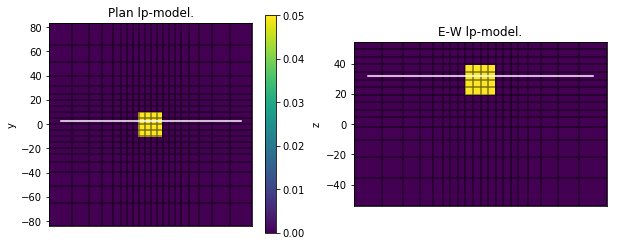

In [4]:
fig = plot_panels(model)
fig.savefig("TrueModel.png")

Begin calculation of forward operator: ind
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Done 100% ...forward operator completed!!



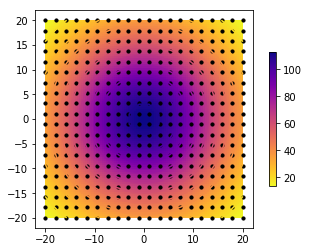

In [5]:
# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, -100)

# Creat reduced identity map
idenMap = Maps.IdentityMap(nP=nC)

# Create the forward model operator
prob = PF.Magnetics.MagneticIntegral(mesh, chiMap=idenMap, actInd=actv)

# Pair the survey and problem
survey.pair(prob)

# Compute linear forward operator and compute some data
d = prob.fields(model)

# Add noise and uncertainties
# We add some random Gaussian noise (1nT)
data = d + np.random.randn(len(d))
wd = np.ones(len(data))*1.  # Assign flat uncertainties

survey.dobs = data
survey.std = wd
survey.mtrue = model

# Plot the data
rxLoc = survey.srcField.rxList[0].locs
PF.Magnetics.plot_obs_2D(rxLoc, d=d)
plt.show()

In [6]:
# Divide the problem into two halves
# Create a mesh
dx = 5.

hxind = [(dx, 5, -1.3), (dx, 10), (dx, 5, 1.3)]
hyind = [(dx, 5, -1.3), (dx, 5), (dx, 5, 1.3)]
hzind = [(dx, 5, -1.3), (dx, 10)]

mesh1 = Mesh.TensorMesh([hxind, hyind, hzind], 'CCC')
mesh1.x0 = np.r_[mesh1.x0[0], mesh1.x0[1]+10, mesh1.x0[2]]

index1 = rxLoc[:,1]>0
rxLoc1 = rxLoc[index1,:]
rx = PF.BaseMag.RxObs(rxLoc1)
srcField = PF.BaseMag.SrcField([rx], param=H0)
survey1 = PF.BaseMag.LinearSurvey(srcField)
survey1.dobs = survey.dobs[index1]

# Create the forward model operator
# Create reduced identity map
tileMap = Maps.Tile((mesh, actv), (mesh1, np.ones(mesh1.nC, dtype='bool')))
tileMap.nCell = 27
prob1 = PF.Magnetics.MagneticIntegral(mesh1, chiMap=tileMap)

# Pair the survey and problem
survey1.pair(prob1)
wr = np.sum((prob1.G*prob1.chiMap.deriv(None))**2., axis = 0)


# Create second local problem
mesh2 = Mesh.TensorMesh([hxind, hyind, hzind], 'CCC')
mesh2.x0 = np.r_[mesh2.x0[0], mesh2.x0[1]-10, mesh2.x0[2]]

index2 = rxLoc[:,1]<=0
rxLoc2 = rxLoc[index2,:]
rx = PF.BaseMag.RxObs(rxLoc2)
srcField = PF.BaseMag.SrcField([rx], param=H0)
survey2 = PF.BaseMag.LinearSurvey(srcField)
survey2.dobs = survey.dobs[index2]

# Create the forward model operator
tileMap = Maps.Tile((mesh, actv), (mesh2, np.ones(mesh2.nC, dtype='bool')))
tileMap.nCell = 27
prob2 = PF.Magnetics.MagneticIntegral(mesh2, chiMap=tileMap)

# Pair the survey and problem
survey2.pair(prob2)
wr += np.sum((prob2.G*prob2.chiMap.deriv(None))**2., axis = 0)




Begin calculation of forward operator: ind
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Done 100% ...forward operator completed!!

Begin calculation of forward operator: ind
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Done 100% ...forward operator completed!!



In [7]:
# Create combo misfit
dmis1 = DataMisfit.l2_DataMisfit(survey1)
dmis1.W = np.ones(survey1.nD)

dmis2 = DataMisfit.l2_DataMisfit(survey2)
dmis2.W = np.ones(survey2.nD)

globalMisfit = dmis1 + dmis2

wr /= wr.max()
wr **= 0.5


SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


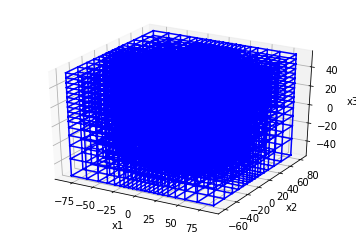

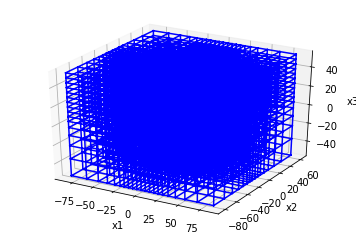

In [8]:
# axs = plt.subplot()
axs = mesh1.plotGrid()
plt.show()

axs = mesh2.plotGrid()
plt.show()


In [9]:

# Create a regularization
reg = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg.cell_weights = wr
# reg.norms = [0, 1, 1, 1]
# reg.eps_p, reg.eps_q = 1e-3, 1e-3


# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=100, lower=0., upper=1.,
                                 maxIterLS=20, maxIterCG=10, tolCG=1e-3)
invProb = InvProblem.BaseInvProblem(globalMisfit, reg, opt)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=3)
update_Jacobi = Directives.UpdatePreconditioner()
inv = Inversion.BaseInversion(invProb,
                              directiveList=[IRLS, betaest, update_Jacobi])

# Run the inversion
m0 = np.ones(nC)*1e-4  # Starting model
mrec = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                              ***Done using same Solver and solverOpts as the MagneticIntegral problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  9.20e+09  7.21e+05  0.00e+00  7.21e+05    6.45e+01      0              
   1  4.60e+09  5.32e+05  8.71e-06  5.72e+05    6.58e+01      0              
   2  2.30e+09  4.13e+05  2.74e-05  4.76e+05    6.41e+01      0   Skip BFGS  
   3  1.15e+09  2.81e+05  6.87e-05  3.60e+05    6.38e+01      0   Skip BFGS  
   4  5.75e+08  1.66e+05  1.40e-04  2.46e+05    6.34e+01      0   Skip BFGS  
   5  2.88e+08  8.85e+04  2.34e-04  1.56e+05    6.28e+01      0   Skip BFGS  
   6  1.44e+08  4.47e+04  3.

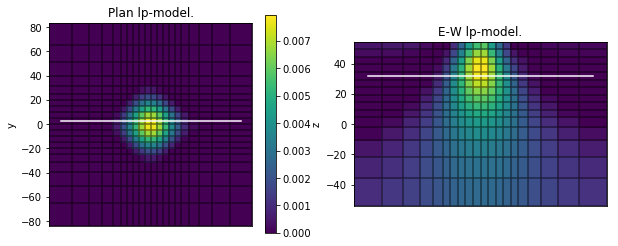

In [13]:
fig = plot_panels(mrec)
fig.savefig("Tiled.png")

Re-run the problem in one shot

In [12]:
wr = np.sum(prob.G**2., axis=0)**0.5
wr /= wr.max()

# Create a regularization
reg = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg.cell_weights = wr

# Create misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = np.ones(survey.nD)

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=100, lower=0., upper=1.,
                                 maxIterLS=20, maxIterCG=10, tolCG=1e-3)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=3)
update_Jacobi = Directives.UpdatePreconditioner()
inv = Inversion.BaseInversion(invProb,
                              directiveList=[IRLS, betaest, update_Jacobi])

# Run the inversion
m0 = np.ones(nC)*1e-4  # Starting model
mrec = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                      ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.72e+10  7.22e+05  0.00e+00  7.22e+05    6.39e+01      0              
   1  8.58e+09  5.90e+05  3.35e-06  6.19e+05    6.55e+01      0              
   2  4.29e+09  4.99e+05  1.11e-05  5.47e+05    6.37e+01      0   Skip BFGS  
   3  2.15e+09  3.78e+05  3.18e-05  4.46e+05    6.35e+01      0   Skip BFGS  
   4  1.07e+09  2.47e+05  7.55e-05  3.28e+05    6.32e+01      0   Skip BFGS  
   5  5.36e+08  1.41e+05  1.45e-04  2.19e+05    6.29e+01  

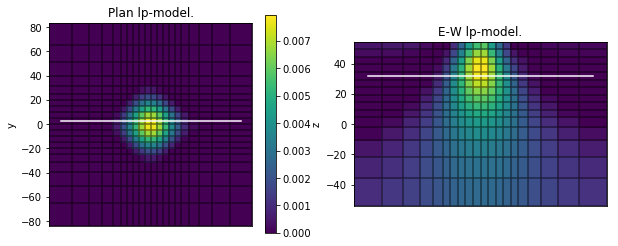

In [14]:
fig = plot_panels(mrec)
fig.savefig("Conventional.png")